In [5]:
import numpy as np
import uproot
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
from scipy import optimize
from src.process_data import process_data
from src.graph import graph
from src.transmission import transmission
from utils import search_asc, search_desc, xsec_to_ts, tof_to_energy, energy_to_tof, chi_sq

In [2]:
from src.process_data import process_data
from src.graph import graph
from src.transmission import transmission

In [3]:
from utils import search_asc, search_desc, xsec_to_ts, tof_to_energy, energy_to_tof, chi_sq

In [6]:
f = open("temp_data/Al.txt")
energy = []
crs = []
for line in f:
    energy.append(float(line[3:14]))
    crs.append(float(line[20:27]))
energy = np.array(energy)
crs = np.array(crs)

In [117]:
tof = energy_to_tof(energy, 181.87, 939.56542, 299792458)[::-1] * 1e9
ts = xsec_to_ts(crs * 1e-28, 9747, 0.03, 3.47e-25)[::-1]

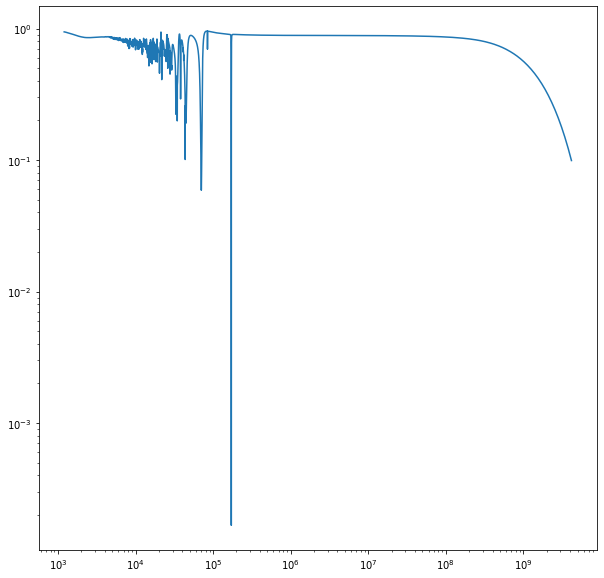

In [34]:
plt.figure(figsize=(10,10))
plt.plot(tof, ts)
plt.xscale('log')
plt.yscale('log')

In [35]:
energy_to_tof(6000 / 1e6, 182.24, 939.56542, 299792458) * 1e9

170097.5166176688

In [131]:
left = search_asc(tof, 171100)
right = search_asc(tof, 171140)

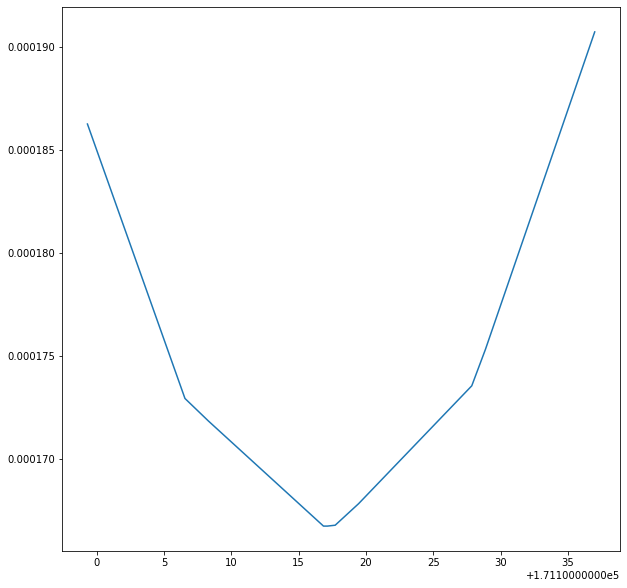

In [132]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [48]:
Al3In = h5py.File("temp_data/Al3.hdf5", "r")
Al3Out = h5py.File("temp_data/empty.hdf5", "r")
amp_Al3In = Al3In['amp'][:]
en_Al3In = Al3In['energy'][:]
tof_Al3In = Al3In['tof'][:]
norm_Al3In = Al3In['norm'][0]
amp_Al3Out = Al3Out['amp'][:]
en_Al3Out = Al3Out['energy'][:]
tof_Al3Out = Al3Out['tof'][:]
norm_Al3Out = Al3Out['norm'][0]

In [133]:
tof_Al3In_select = tof_Al3In[(tof_Al3In > 171100) & (tof_Al3In < 171140) & (amp_Al3In > 4000)]

In [134]:
tof_Al3In_select

array([171124.44292412])

In [135]:
1 / norm_Al3In

6.637190034512154e-18

In [51]:
energy_to_tof(5000 / 1e6, 182.24, 939.56542, 299792458) * 1e9

186332.34491698188

In [52]:
energy_to_tof(7000 / 1e6, 182.24, 939.56542, 299792458) * 1e9

157479.82551188226

In [54]:
tof_Al3In_select = tof_Al3In[(en_Al3In > 5000) & (en_Al3In < 7000) & (amp_Al3In > 4000)]
tof_Al3Out_select = tof_Al3Out[(en_Al3Out > 5000) & (en_Al3Out < 7000) & (amp_Al3Out > 4000)]

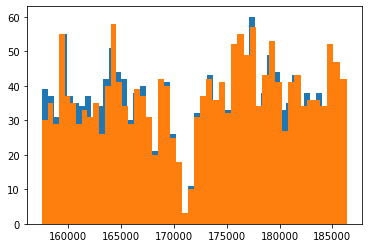

In [55]:
hist_Al3In, bins_Al3In, _, _ = graph(tof_Al3In_select, 50)

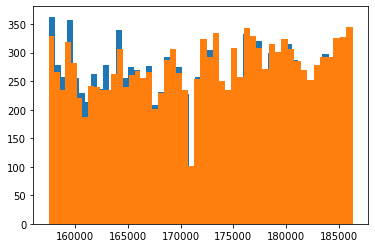

In [56]:
hist_Al3Out, bins_Al3Out, _, _ = graph(tof_Al3Out_select, 50)

In [57]:
x_tof = (bins_Al3In[1:] + bins_Al3In[:-1]) / 2

In [58]:
error_Al3In =  np.sqrt(hist_Al3In)
error_Al3In[error_Al3In == 0] = 0.7

In [59]:
tr, tr_error = transmission(hist_Al3In / norm_Al3In, error_Al3In / norm_Al3In, hist_Al3Out / norm_Al3Out, np.sqrt(hist_Al3Out) / norm_Al3Out)

<ErrorbarContainer object of 3 artists>

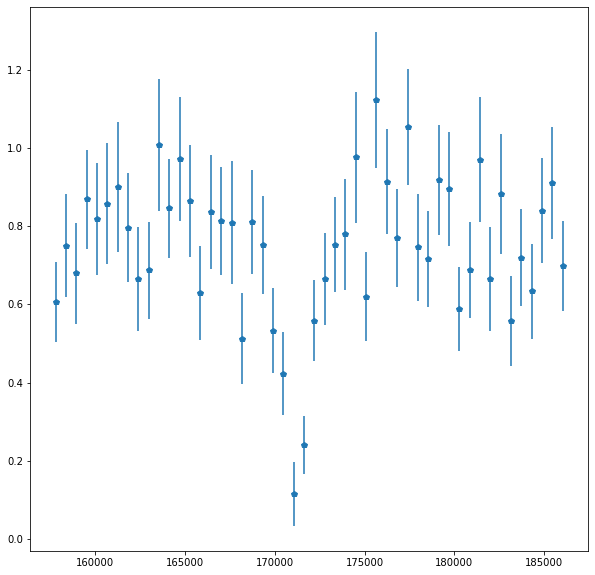

In [60]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error, fmt="p")

In [62]:
y_ts = []
for x in x_tof:
    index = search_asc(tof, x)
    y = ts[index]
    y_ts.append(y)

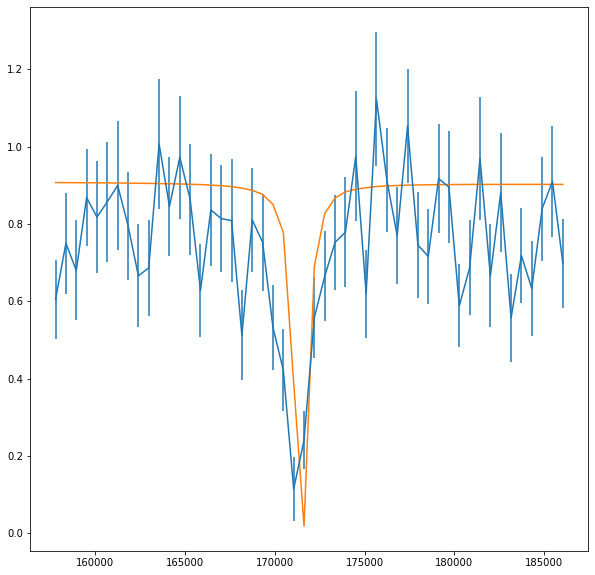

In [63]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error)
plt.plot(x_tof, y_ts)

In [64]:
def chi_sq(tr, tr_error, L, t, x_tof, crs, energy):
    ts = xsec_to_ts(np.array(crs) * 1e-28, 9747, t, 3.47e-25)[::-1]
    tof = energy_to_tof(energy, L, 939.56542, 299792458)[::-1] * 1e9
    y_ts = []
    for x in x_tof:
        y_ts.append(np.interp(x, tof, ts))
    y_ts = np.array(y_ts)
    r = y_ts - tr
    chi_sq = np.sum((r / tr_error) ** 2)
    return chi_sq

In [66]:
chi_sqs = []
Ls = np.linspace(181,184,301)

In [67]:
for L in Ls:
    chi_sqs.append(chi_sq(tr, tr_error, L, 0.01, x_tof, crs, energy))

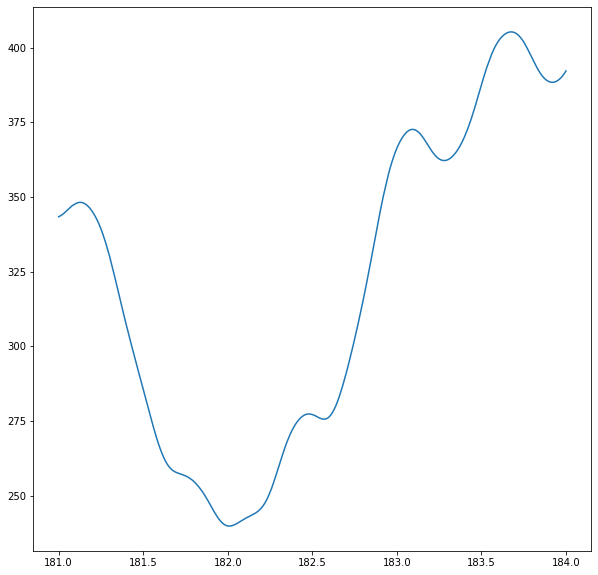

In [68]:
plt.figure(figsize=(10,10))
plt.plot(Ls, chi_sqs)
#plt.yscale('log')

In [69]:
min_idx = 0
min_chi = float('inf')
for i in range(301):
    if chi_sqs[i] < min_chi:
        min_chi = chi_sqs[i]
        min_idx = i

In [70]:
min_idx

101

In [71]:
min_chi

239.85780299053977

In [72]:
Ls[101]

182.01

In [106]:
chi_sqs2 = []
ths = np.linspace(0.074,0.078,301)

In [107]:
for th in ths:
    chi_sqs2.append(chi_sq(tr, tr_error, 182.36, th, x_tof, crs, energy))

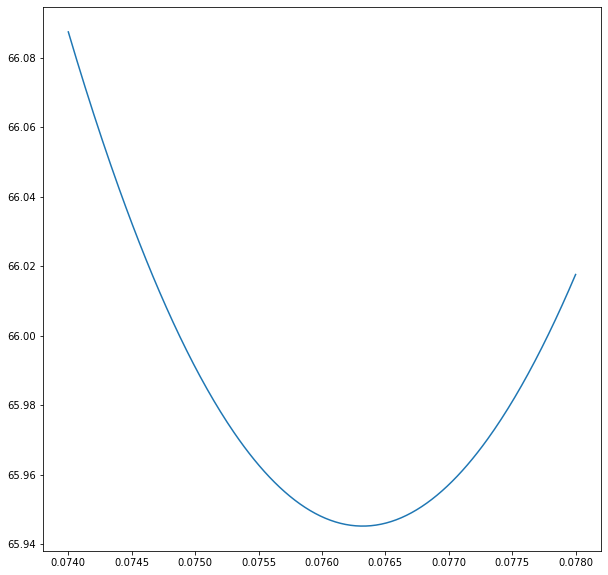

In [108]:
plt.figure(figsize=(10,10))
plt.plot(ths, chi_sqs2)

In [109]:
min_idx2 = 0
min_chi2 = float('inf')
for i in range(301):
    if chi_sqs2[i] < min_chi2:
        min_chi2 = chi_sqs2[i]
        min_idx2 = i

In [110]:
min_idx2

174

In [111]:
min_chi2

65.94514607265742

In [112]:
ths[min_idx2]

0.07632

In [113]:
def y_fit(energy, L, t):
    ts = xsec_to_ts(np.array(crs) * 1e-28, 9747, t, 3.47e-25)[::-1]
    tof = energy_to_tof(energy, L, 939.56542, 299792458)[::-1] * 1e9
    y_ts = []
    for x in x_tof:
        y_ts.append(np.interp(x, tof, ts))
    y_ts = np.array(y_ts)
    return y_ts

In [114]:
fit, sig = optimize.curve_fit(y_fit, energy, tr, sigma=tr_error, p0=[182.24, 0.01], absolute_sigma=True)

In [115]:
fit

array([1.81871877e+02, 7.36897732e-02])

In [116]:
np.sqrt(np.diag(sig))

array([0.06642005, 0.00606772])

In [136]:
tof = energy_to_tof(energy, 181.87, 939.56542, 299792458)[::-1] * 1e9
ts = xsec_to_ts(crs * 1e-28, 9747, 0.05, 3.47e-25)[::-1]

In [143]:
left = search_asc(tof, 171000)
right = search_asc(tof, 171250)

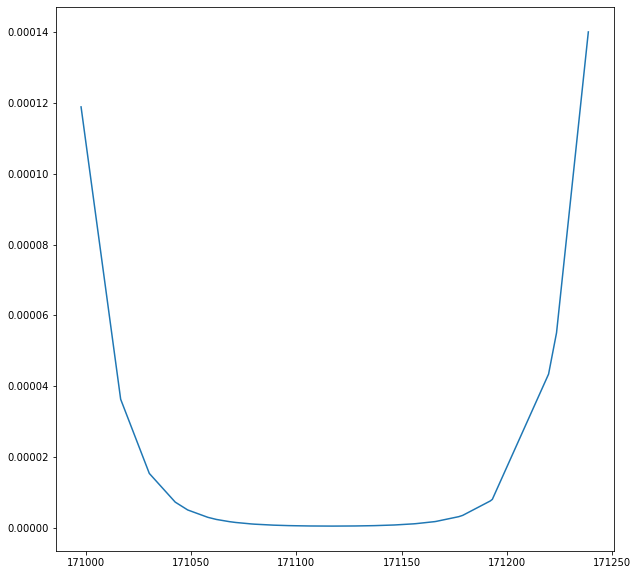

In [144]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [145]:
Al5In = h5py.File("temp_data/Al5.hdf5", "r")
Al5Out = h5py.File("temp_data/empty.hdf5", "r")
amp_Al5In = Al5In['amp'][:]
en_Al5In = Al5In['energy'][:]
tof_Al5In = Al5In['tof'][:]
norm_Al5In = Al5In['norm'][0]
amp_Al5Out = Al5Out['amp'][:]
en_Al5Out = Al5Out['energy'][:]
tof_Al5Out = Al5Out['tof'][:]
norm_Al5Out = Al5Out['norm'][0]

In [147]:
tof_Al5In_select = tof_Al5In[(tof_Al5In > 171000) & (tof_Al5In < 171250) & (amp_Al5In > 4000)]

In [148]:
tof_Al5In_select

array([], dtype=float64)

In [149]:
tof_Al5In_select = tof_Al5In[(en_Al5In > 5000) & (en_Al5In < 7000) & (amp_Al5In > 4000)]
tof_Al5Out_select = tof_Al5Out[(en_Al5Out > 5000) & (en_Al5Out < 7000) & (amp_Al5Out > 4000)]

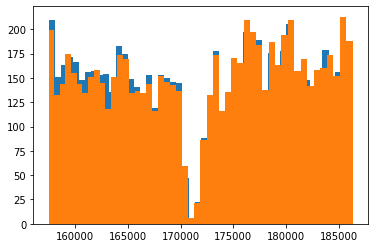

In [150]:
hist_Al5In, bins_Al5In, _, _ = graph(tof_Al5In_select, 50)

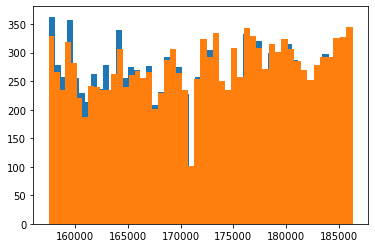

In [151]:
hist_Al5Out, bins_Al5Out, _, _ = graph(tof_Al5Out_select, 50)

In [152]:
x_tof = (bins_Al5In[1:] + bins_Al5In[:-1]) / 2

In [153]:
error_Al5In =  np.sqrt(hist_Al5In)
error_Al5In[error_Al5In == 0] = 0.7

In [154]:
tr, tr_error = transmission(hist_Al5In / norm_Al5In, error_Al5In / norm_Al5In, hist_Al5Out / norm_Al5Out, np.sqrt(hist_Al5Out) / norm_Al5Out)

<ErrorbarContainer object of 3 artists>

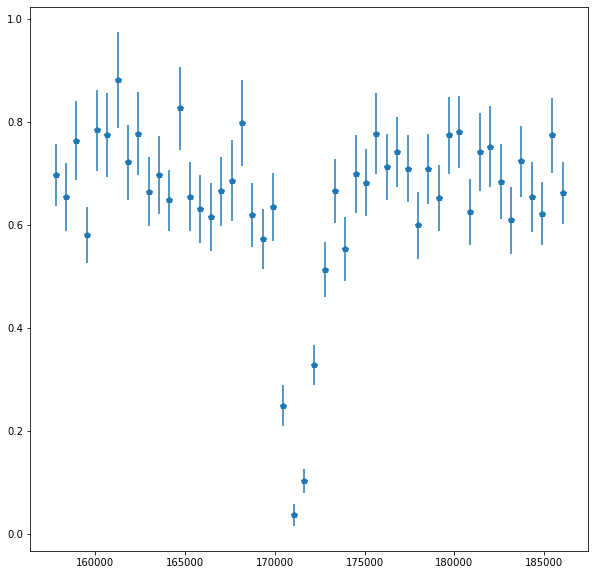

In [155]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error, fmt="p")

In [156]:
y_ts = []
for x in x_tof:
    index = search_asc(tof, x)
    y = ts[index]
    y_ts.append(y)

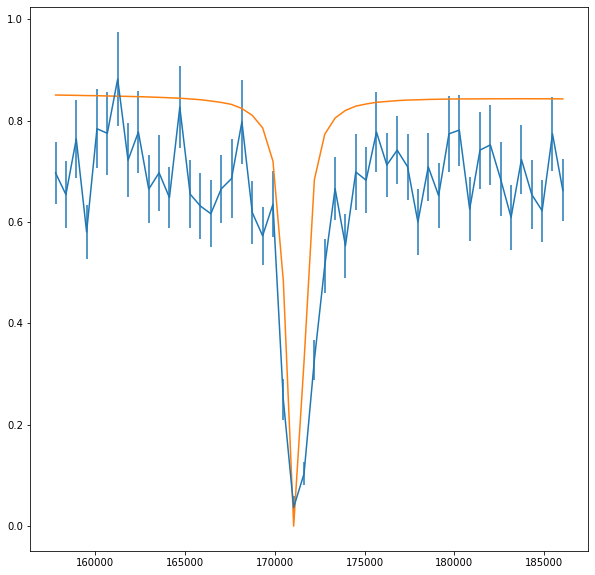

In [157]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error)
plt.plot(x_tof, y_ts)

In [158]:
fit, sig = optimize.curve_fit(y_fit, energy, tr, sigma=tr_error, p0=[182.24, 0.01], absolute_sigma=True)

In [159]:
fit

array([1.81909230e+02, 1.08091383e-01])

In [160]:
np.sqrt(np.diag(sig))

array([0.03006216, 0.00360868])

In [161]:
tof = energy_to_tof(energy, 181.87, 939.56542, 299792458)[::-1] * 1e9
ts = xsec_to_ts(crs * 1e-28, 9747, 0.08, 3.47e-25)[::-1]

In [178]:
left = search_asc(tof, 170900)
right = search_asc(tof, 171350)

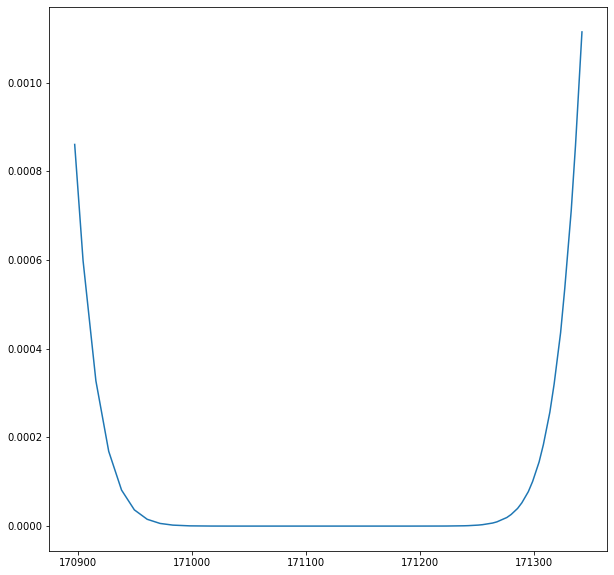

In [179]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])

In [180]:
Al8In = h5py.File("temp_data/Al8.hdf5", "r")
Al8Out = h5py.File("temp_data/empty.hdf5", "r")
amp_Al8In = Al8In['amp'][:]
en_Al8In = Al8In['energy'][:]
tof_Al8In = Al8In['tof'][:]
norm_Al8In = Al8In['norm'][0]
amp_Al8Out = Al8Out['amp'][:]
en_Al8Out = Al8Out['energy'][:]
tof_Al8Out = Al8Out['tof'][:]
norm_Al8Out = Al8Out['norm'][0]

In [182]:
tof_Al8In_select = tof_Al8In[(tof_Al8In > 170900) & (tof_Al8In < 171350) & (amp_Al8In > 4000)]

In [183]:
tof_Al8In_select

array([171312.87442207])

In [184]:
1 / norm_Al8In

6.415474963713075e-18

In [185]:
tof_Al8In_select = tof_Al8In[(en_Al8In > 5000) & (en_Al8In < 7000) & (amp_Al8In > 4000)]
tof_Al8Out_select = tof_Al8Out[(en_Al8Out > 5000) & (en_Al8Out < 7000) & (amp_Al8Out > 4000)]

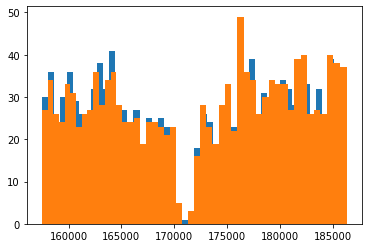

In [186]:
hist_Al8In, bins_Al8In, _, _ = graph(tof_Al8In_select, 50)

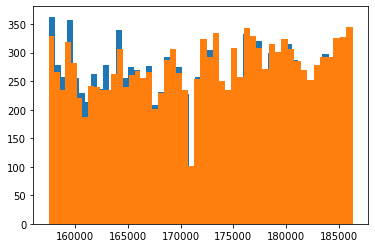

In [187]:
hist_Al8Out, bins_Al8Out, _, _ = graph(tof_Al8Out_select, 50)

In [188]:
x_tof = (bins_Al8In[1:] + bins_Al8In[:-1]) / 2

In [189]:
error_Al8In =  np.sqrt(hist_Al8In)
error_Al8In[error_Al8In == 0] = 0.7

In [190]:
tr, tr_error = transmission(hist_Al8In / norm_Al8In, error_Al8In / norm_Al8In, hist_Al8Out / norm_Al8Out, np.sqrt(hist_Al8Out) / norm_Al8Out)

<ErrorbarContainer object of 3 artists>

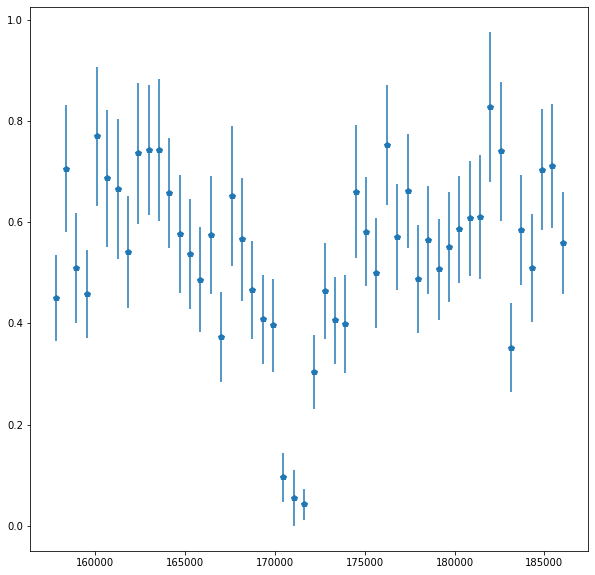

In [191]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error, fmt="p")

In [194]:
y_ts = []
for x in x_tof:
    y_ts.append(np.interp(x, tof, ts))

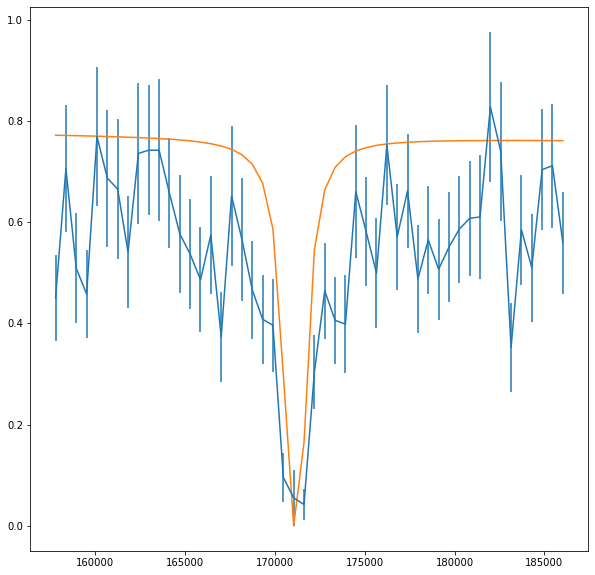

In [195]:
plt.figure(figsize=(10,10))
plt.errorbar(x_tof, tr, yerr=tr_error)
plt.plot(x_tof, y_ts)

In [196]:
fit, sig = optimize.curve_fit(y_fit, energy, tr, sigma=tr_error, p0=[182.24, 0.01], absolute_sigma=True)

In [197]:
fit

array([1.81857742e+02, 1.63760249e-01])

In [198]:
np.sqrt(np.diag(sig))

array([0.06702597, 0.00758779])